# Introduction

In my [previous post](https://alanbertl.com/autoencoder-with-fast-ai/) I demonstrated the concept of an autoencoder, a machine learning system that learns to output its input and in the process works toward some auxiliary objective.  

In this project, I'm going to introduce the concept of a GAN, and use an autoencoder to give a boost to the training process.

# What is a GAN?

[GAN](https://en.wikipedia.org/wiki/Generative_adversarial_network) stands for *Generative Adversarial Network*.  *Generative* means the system will create content (in this case, images) rather than, say, classifying it.  *Adversarial* means the system will train its components competitively.  *Network* because the system will be implemented as a neural network.

The diagram below depicts GAN structure.  I will describe the structure in terms of a GAN that generates images.

<img src="https://alanbertl.com/wp-content/uploads/2018/12/GAN.png"></img>

A GAN consists of two main components, the generator and the discriminator.  The generator generates an image seeded by a random input.  The discriminator is a classifier that takes as input *either* an image from the generator *or* an image from a preselected dataset containing images typical of what we wish to train the generator to produce.  

The key is that the generator and discriminator are trained toward cross-purposes.  The discriminator is trained to identify which images are "real", i.e. originating from the dataset or "fake", originating from the generator.  The generator is trained to fool the discriminator.  

In principle, as the discriminator gets better at distinguishing real from generated images, the generator must produce images that more convincingly blend into the dataset, which is our ultimate goal.  In practice, it's hard to set up a GAN to reliably train, and this is still an active area of research.

For this project my original goal was to work through a [notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/wgan.ipynb) featuring a GAN that appeared in the 2018 version of [fast.ai](https://www.fast.ai/)'s [online course](https://course.fast.ai/part2.html).  When I ran into trouble getting the network to train, I found a solution involving an autoencoder.

# Setup

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

This code uses an old version (0.7) of the fast.ai library, which I've symlinked under oldfastai.

In [2]:
from oldfastai.conv_learner import *
from oldfastai.dataset import *
import gzip
torch.cuda.set_device(0)

We will use a portion of the [LSUN](https://www.yf.io/p/lsun) [scene classification dataset](http://lsun.cs.princeton.edu/2017/#scene), specifically a 20% sample of the bedroom scenes which can be downloaded [here](https://www.kaggle.com/jhoward/lsun_bedroom).

In [3]:
PATH = Path('data/lsun/')
IMG_PATH = PATH/'bedroom'
CSV_PATH = PATH/'files.csv'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

The dataset has a complicated directory structure.  Here we just want to use all the images.

In [4]:
files = PATH.glob('bedroom/**/*.jpg')

with CSV_PATH.open('w') as fo:
    for f in files: fo.write(f'{f.relative_to(IMG_PATH)},0\n')

## Define Encoder / Decoder

The code for the discriminator, generator, their components, some utility functions, and the training loop is courtesy of [Jeremy Howard](https://twitter.com/jeremyphoward) and is pulled directly from the aforementioned [notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/wgan.ipynb).

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [6]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = []
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

Jeremy mentions artifacts being an issue with the ConvTranspose operation, but uses it here anyway (presumably it worked well enough for this purpose).  ConvTranspose has worked fine for me in building an autoencoder for MNIST but it may be the culprit of noticeable artifacts that can be seen later.  Perhaps something that can be improved.

In [7]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [8]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]

        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2

        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, input): return F.tanh(self.features(input))

Batch size, working image size, and dimension of our latent variables.

In [9]:
bs,sz,nz = 64,64,100

Create our modeldata...

In [10]:
tfms = tfms_from_stats(inception_stats, sz)
md = ImageClassifierData.from_csv(PATH, 'bedroom', CSV_PATH, tfms=tfms, bs=128,
                                  skip_header=False, continuous=True)

In [11]:
md = md.resize(128)

In [12]:
x,_ = next(iter(md.val_dl))

We're going to be training our GAN to create images of bedrooms like this:

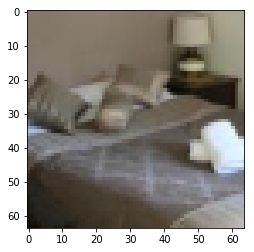

In [13]:
plt.imshow(md.trn_ds.denorm(x)[0]);

Initial instantiation of our generator and discriminator.

In [14]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

A function to pick random vectors of dimension 100 from a standard normal distribution.

In [15]:
def create_noise(b): return V(torch.zeros(b, nz, 1, 1).normal_(0, 1))

Initial results of our generator.  We don't expect much from a randomly initialized generator.

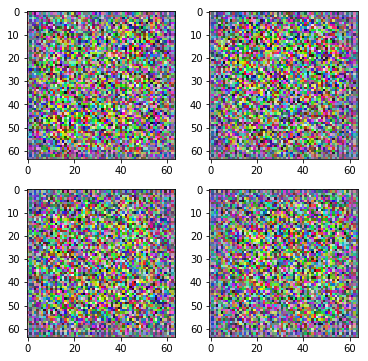

In [16]:
nn.functional.tanh = torch.tanh

preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

In [17]:
def gallery(x, nc=3):
    n,h,w,c = x.shape
    nr = n//nc
    assert n == nr*nc
    return (x.reshape(nr, nc, h, w, c)
              .swapaxes(1,2)
              .reshape(h*nr, w*nc, c))

Training a GAN is different from a classifier.  Jeremy implements a GAN training cycle manually.

In [18]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        with tqdm(total=n) as pbar:
            while i < n:
                set_trainable(netD, True)
                set_trainable(netG, False)
                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
                j = 0
                while (j < d_iters) and (i < n):
                    j += 1; i += 1
                    for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    real = V(next(data_iter)[0])
                    real_loss = netD(real)
                    fake = netG(create_noise(real.size(0)))
                    fake_loss = netD(V(fake.data))
                    netD.zero_grad()
                    lossD = real_loss-fake_loss
                    lossD.backward()
                    optimizerD.step()
                    pbar.update()

                set_trainable(netD, False)
                set_trainable(netG, True)
                netG.zero_grad()
                lossG = netD(netG(create_noise(bs))).mean(0).view(1)
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
            
        print(f'Loss_D {to_np(lossD)}; Loss_G {to_np(lossG)}; '
              f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')

In [19]:
len(md.trn_dl)

5684

# Initial attempts to train

In [20]:
torch.backends.cudnn.benchmark=True

In [21]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

In [22]:
train(1, True)

100%|██████████| 1895/1895 [03:49<00:00,  7.27it/s]
Loss_D [-1.61107]; Loss_G [0.82273]; D_real [-0.80454]; Loss_D_fake [0.80653]
100%|██████████| 1/1 [03:49<00:00, 229.81s/it]

In [23]:
set_trainable(netD, True)
set_trainable(netG, True)
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-5)

In [24]:
train(1, False)

100%|██████████| 1895/1895 [04:03<00:00,  9.81it/s]
Loss_D [-1.59932]; Loss_G [0.79808]; D_real [-0.80353]; Loss_D_fake [0.79578]
100%|██████████| 1/1 [04:03<00:00, 243.60s/it]

Here are the results of the generator producing 4 images from 4 random vectors.  Not much progress, it seems.

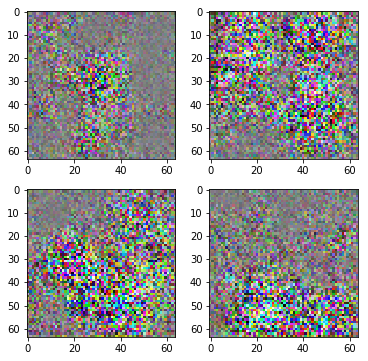

In [25]:
preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

Let's try more training.

In [26]:
train(5, False)

100%|██████████| 1895/1895 [04:04<00:00,  9.61it/s]
Loss_D [-1.58158]; Loss_G [0.78009]; D_real [-0.8021]; Loss_D_fake [0.77948]
100%|██████████| 1895/1895 [04:04<00:00,  9.58it/s]
Loss_D [-1.57082]; Loss_G [0.77181]; D_real [-0.80185]; Loss_D_fake [0.76897]
100%|██████████| 1895/1895 [04:05<00:00,  9.56it/s]
Loss_D [-1.56607]; Loss_G [0.76721]; D_real [-0.80176]; Loss_D_fake [0.76432]
100%|██████████| 1895/1895 [04:05<00:00,  9.57it/s]
Loss_D [-1.56538]; Loss_G [0.76113]; D_real [-0.80235]; Loss_D_fake [0.76303]
100%|██████████| 1895/1895 [04:02<00:00,  9.54it/s]
Loss_D [-1.56043]; Loss_G [0.75779]; D_real [-0.80243]; Loss_D_fake [0.758]
100%|██████████| 5/5 [20:23<00:00, 244.31s/it]

Here again is a sample of the types of images the generator is producing.

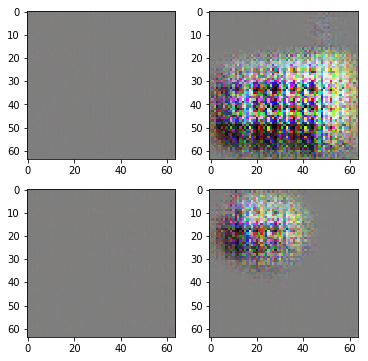

In [27]:
preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

Let's create a static set of one batch random vectors and track what the generator produces from those particular vectors.

In [28]:
fixed_noise = create_noise(bs)

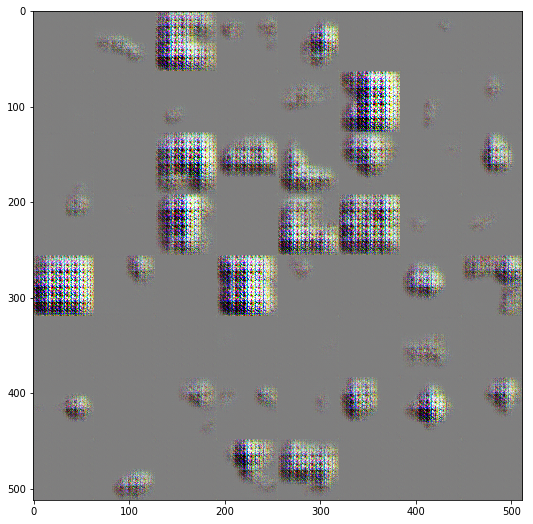

In [29]:
netD.eval(); netG.eval();
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));

It's hard to tell that's an $8\times 8$ array of images.

# Autoencoder

Well that didn't work the way it was supposed to.  A possible explanation for the discrepency between Jeremy's results and mine are that Jeremy used the full complement of the bedroom scenes in the LSUN dataset rather than the 20% sample I used.  Another possibility is that Jeremy trained his GAN more than the few cycles he displayed in his notebook.  It was at this point I decided to try an idea I had for pretraining.

<img src="https://alanbertl.com/wp-content/uploads/2018/12/pretrainingWGAN.png"></img>

In a WGAN, the discriminator encodes the high dimensional image space to a lower dimensional latent-variable space and classifies it (real or fake) while the generator figures out how to turn a low(ish) dimensional latent random variable space and decode it into the high dimensional image space.  This sounds like, respectively, the encoder and decoder of an autoencoder!  A small problem is that the discriminator outputs a single number in the space $[-1,1]$ while the generator takes a vector from $\mathbb{R}^n$, but we can fix that by stripping off enough layers of the discriminator to get to higher dimensional space, and adding a translation layer that outputs in $\mathbb{R}^n$.

Why do this?  Well firstly autoencoders are not that hard to train.  Secondly I suspected that if the generator had some training in taking an encoding and generating bedroom images (specific images in fact) that would be helpful in producing bedroom-like images in general.  Meanwhile the decoder would get some practice in extracting useful information from bedroom images.

The first thing we'll do is recreate the GAN.  We're setting up an experiment to see whether pretraining a GAN as an autoencoder in this case is better than purely training as a GAN.  With that in mind, we need to compare them directly, so it's not fair for the autoencoder method to benefit from the GAN training that's already occurred.

In [30]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

## Define autoencoder model

The summary provided by PyTorch / fast.ai isn't always helpful in determining the inputs and outputs of certain layers of the model(s), so I typically create a Torch tensor for testing.

In [31]:
x = T(md.val_ds[0][0].reshape((1,3,64,64)))

In [32]:
nn.Sequential(*children(netD)[:-1])(x).size()

torch.Size([1, 512, 4, 4])

It looks like if we strip off the last layer of the discriminator, we get an output that is $\mbox{bs}\times 512\times 4\times 4$, or a batch of 512 features each of which is a $4\times 4$ array.  This is certainly high enough dimension for our purposes.

We need to add a translation layer, so we'll do a convolutional layer with a $4\times 4$ kernel, no padding, and an output of 100 features.  This is similar to what the layer we removed from the discriminator did.

In [33]:
dec = nn.Sequential(*children(netD)[:-1]+[nn.Conv2d(512,100,4,bias=False)]).cuda()
dec(x).size()

torch.Size([1, 100, 1, 1])

We check, and voila!  The shape matches the output of create_noise, which goes straight into netG.

In [34]:
create_noise(1).size()

torch.Size([1, 100, 1, 1])

Now we assemble the autoencoder.

In [35]:
autoenc = (nn.Sequential(dec,netG)).cuda()

Let's just make sure everything is lined up internally.

In [36]:
autoenc(x).size()

torch.Size([1, 3, 64, 64])

## Create ModelData

An autoencoder is just a special case of a deep regression network, so we can leverage the standard fast.ai library.

Here's what the csv file we created earlier looks like.  The column I've labelled "N/A" doesn't do anything.  I assume it's there because the default behavior of fast.ai when creating modeldata from a csv is to look for filename/label pairs.  For the GAN we're not interested in labels, and for the autoencoder the input and label are the same.

In [37]:
fn_df = pd.read_csv(CSV_PATH,header=None)
fn_df.columns = ["fn","N/A"]
fn_df.head()

fn  N/A
0  6/6/6/6665895c733abe47c83266d68973e605a15dad9d...    0
1  6/6/6/6667dfd98b6291f5e770741b24221ed2beca1669...    0
2  6/6/6/666262dcfc7a10542fc78931d2cdeee83fb9ceb3...    0
3  6/6/6/6667ebf9a0bbb16a16b459fbe282af574f496474...    0
4  6/6/6/6669ab29c7de5e44fc9b84d86b63aa21a0e0b2db...    0

Presumably we could use the csv file or the dataframe to make a dataset of data/label pairs for the autoencoder, but I found the following piece of code in a different [notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/carvana.ipynb) for the fast.ai course, which uses an array of Path objects.

In [38]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

That's easy enough to create.

In [39]:
%time fns = np.array(['bedroom'/Path(row["fn"]) for i,row in fn_df.iterrows()])

CPU times: user 58.7 s, sys: 0 ns, total: 58.7 s
Wall time: 58.7 s


In [40]:
fns[:5]

array([PosixPath('6/6/6/6665895c733abe47c83266d68973e605a15dad9d.jpg'),
       PosixPath('6/6/6/6667dfd98b6291f5e770741b24221ed2beca1669.jpg'),
       PosixPath('6/6/6/666262dcfc7a10542fc78931d2cdeee83fb9ceb3.jpg'),
       PosixPath('6/6/6/6667ebf9a0bbb16a16b459fbe282af574f496474.jpg'),
       PosixPath('6/6/6/6669ab29c7de5e44fc9b84d86b63aa21a0e0b2db.jpg')], dtype=object)

I pulled out and modified the following code from the same notebook, which also suits our purpose.  This creates a list of validation ids, and specifies the data transformations to due for augmentation.

In [41]:
val_idxs = list(range(len(fns)//5))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, fns, fns)

In [42]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
            RandomFlip(tfm_y=TfmType.PIXEL),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.PIXEL)]

Now we create datasets and get our ModelData object.

In [43]:
ae_tfms = tfms_from_stats(inception_stats, sz, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
ae_datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), ae_tfms, path=PATH)
ae_md = ImageData(PATH, ae_datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm
ae_md = ae_md.resize(128)

Check to make sure we're getting what we expect from the dataloader.

In [44]:
x,y = next(iter(ae_md.trn_dl))

In [45]:
x.shape,y.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64, 3, 64, 64]))

Now since everything is set up according to the way fast.ai is designed, we can go ahead and grab a learner with all it's bells and whistles.  I didn't give too much thought to the optimizer and loss function, I just used what's worked for me with autoencoders before.  From what I understand, it's better practice to include the encoded feature vector as part of the cost, but I'm not going to do any of that.

In [46]:
learn = Learner.from_model_data(autoenc, ae_md, opt_fn = optim.Adam, crit = F.mse_loss)

## Find learning rate

In [48]:
learn.lr_find(start_lr = 1e-4)

 59%|█████▉    | 2228/3790 [05:27<01:14, 20.89it/s, loss=0.151] 

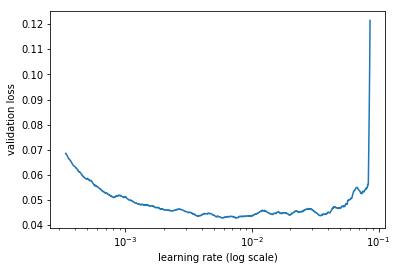

In [49]:
learn.sched.plot(n_skip=400)

From the above, I chose a learning rate of .001.  Now let's train for a cycle using an adaptive learning rate and see how we do.

## Autoencoder training

In [50]:
lr = 1e-3
learn.fit(lr, 1, use_clr_beta=(20,10,15), cycle_len = 1)

epoch      trn_loss   val_loss                                  
    0      0.035785   0.033765  


[0.03376472003275586]

In [ ]:
# learn.load(f'AE_ph1') # Load if autoencoder has already been trained.

A look at how the autoencoder is performing.

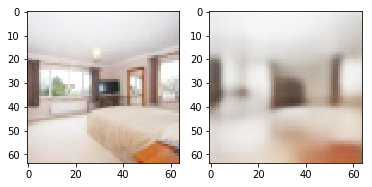

In [51]:
i=1
fig = plt.figure()
((ax1,ax2)) = fig.subplots(1,2)
ax1.imshow(denorm(x)[i])
ax2.imshow(denorm(learn.model(x))[i])

Not bad!  We could train some more, but our purpose isn't really to make an autoencoder, it's to jumpstart a WGAN.  Let's save and get back to business.

In [52]:
learn.save(f'AE_ph1')

One nice thing about how everything is set up, is that netG and the decoder layer of our autoencoder are the same instance...

In [53]:
netG is children(autoenc)[1]

True

...and similarly all the layers of the encoder-part of our autoencoder are the same instances as all but the last layer of our discriminator.

In [54]:
all((a is b for a,b in zip(children(autoenc)[0],children(netD)[:-1])))

True

That means we can use the netG and netD as they are, without having to reinstance or copy over parameters.  Similarly if the need arises we can switch back and forth between training the autoencoder and WGAN relatively painlessly (with a caveat I'll mention later).

Just for fun let's see how our gallery looks after training netG with the autoencoder.

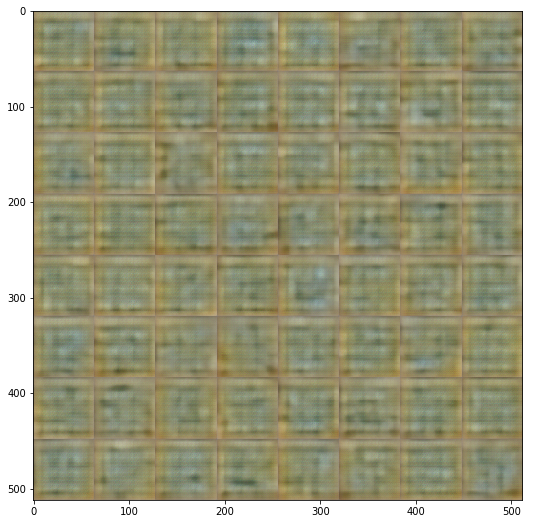

In [55]:
netD.eval(); netG.eval();
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));

It certainly looks different, but it's still a far cry from looking like bedrooms.  Here's 4 generated from new random noise.

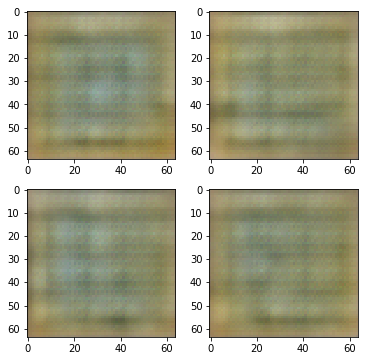

In [56]:
preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

# WGAN training, attempt \#2

In [57]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

In [58]:
train(1, True)

100%|██████████| 1895/1895 [03:44<00:00, 10.33it/s]
Loss_D [-0.79862]; Loss_G [0.7388]; D_real [-0.54513]; Loss_D_fake [0.25349]
100%|██████████| 1/1 [03:44<00:00, 224.54s/it]

In [59]:
set_trainable(netD, True)
set_trainable(netG, True)
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-5)

In [60]:
train(1, False)

100%|██████████| 1895/1895 [04:03<00:00,  9.51it/s]
Loss_D [-1.49404]; Loss_G [0.75309]; D_real [-0.7464]; Loss_D_fake [0.74763]
100%|██████████| 1/1 [04:03<00:00, 243.38s/it]

Looking at our gallery again, suddenly things have improved!

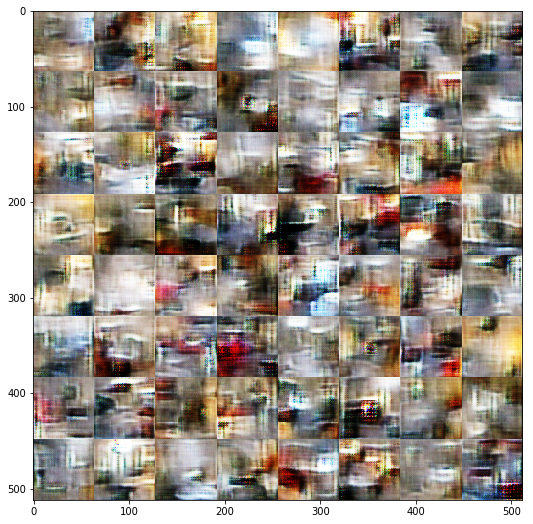

In [61]:
netD.eval(); netG.eval();
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));

Looking more closely, we can see that there's a lot of progress to be made, but the images are at least plausibly bedroom-like.

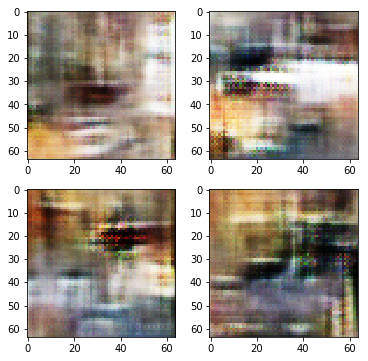

In [62]:
preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

Meanwhile, how is the network doing as an autoencoder?

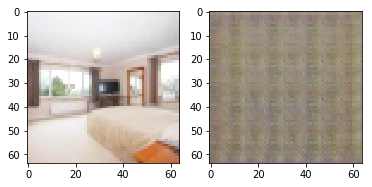

In [63]:
i=1
fig = plt.figure()
((ax1,ax2)) = fig.subplots(1,2)
ax1.imshow(denorm(x)[i])
ax2.imshow(denorm(learn.model(x))[i])

Oops, not good.  That's no surprise though since we've trained all the weights in the decoder layer *except* the translation layer, optimizing them for something the translation layer knows nothing about.

In [64]:
learn.save(f"AE_ph2")

In [65]:
learn.load(f"AE_ph2")

In [66]:
train(2, False)

100%|██████████| 5684/5684 [12:57<00:00,  4.45it/s]
Loss_D [-1.47055]; Loss_G [0.74265]; D_real [-0.72875]; Loss_D_fake [0.7418]
100%|██████████| 5684/5684 [12:51<00:00,  7.36it/s]
Loss_D [-1.45275]; Loss_G [0.72803]; D_real [-0.71246]; Loss_D_fake [0.74029]
100%|██████████| 2/2 [25:49<00:00, 775.69s/it]

Further training seems to be moving things in the right direction.

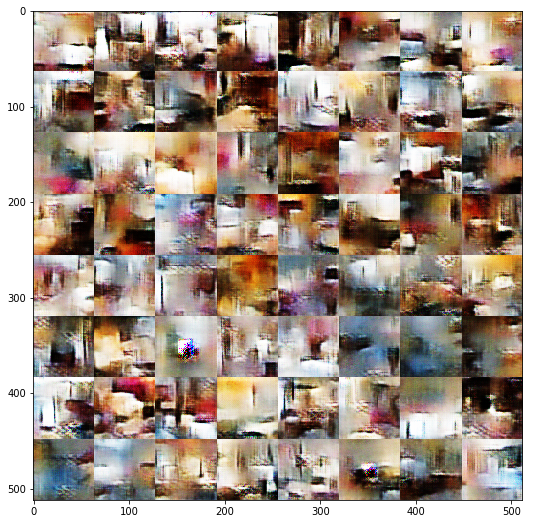

In [67]:
netD.eval(); netG.eval();
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));

In [68]:
learn.save(f"AE_ph3")

In [69]:
learn.load(f"AE_ph3")

In [70]:
train(5, False)

100%|██████████| 5684/5684 [12:18<00:00,  7.69it/s]
Loss_D [-1.45951]; Loss_G [0.7235]; D_real [-0.72002]; Loss_D_fake [0.7395]
100%|██████████| 5684/5684 [12:42<00:00,  7.46it/s]
Loss_D [-1.41781]; Loss_G [0.71974]; D_real [-0.69036]; Loss_D_fake [0.72744]
100%|██████████| 5684/5684 [12:24<00:00,  7.63it/s]
Loss_D [-1.44386]; Loss_G [0.70684]; D_real [-0.70937]; Loss_D_fake [0.73449]
100%|██████████| 5684/5684 [12:56<00:00,  7.32it/s]
Loss_D [-1.42785]; Loss_G [0.7143]; D_real [-0.71074]; Loss_D_fake [0.71711]
100%|██████████| 5684/5684 [17:14<00:00,  5.23it/s]
Loss_D [-1.41855]; Loss_G [0.70775]; D_real [-0.69168]; Loss_D_fake [0.72687]
100%|██████████| 5/5 [1:07:37<00:00, 838.79s/it]

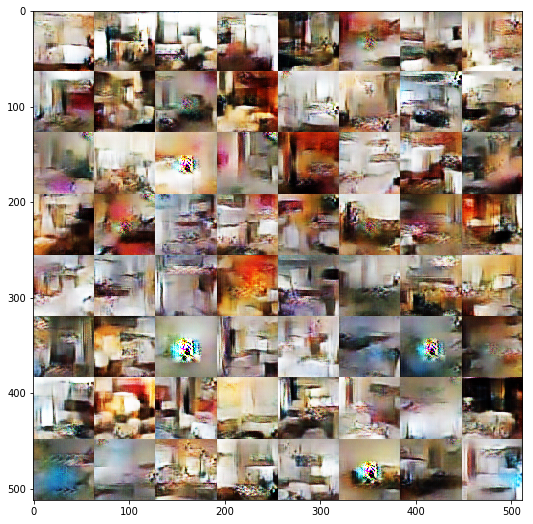

In [71]:
netD.eval(); netG.eval();
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));

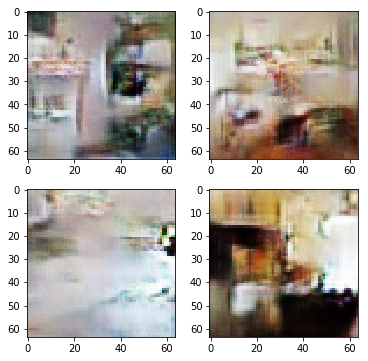

In [72]:
preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

In [73]:
learn.save(f"AE_ph4")

Etc.  

In summary repurposing the GAN as an autoencoder was successful as a form of pretraining.  Something I'll keep in mind for the future. 

If you'd like to try out this notebook, you can download it <a href="https://alanbertl.com/wp-content/uploads/2018/12/GAN-autoencoder.ipynb" download>here</a>.  You'll need [Jupyter](https://jupyter.org/).